# ⚡ Notebook 2: Multi-Campaign Comparison & Learning

**Objective:** Track how understanding evolves across experimental campaigns - making learning compound, not fragment.

**Why this matters for materials discovery:**
In iterative discovery loops, each campaign should build on previous insights:
- Are success rates improving as protocols are refined?
- Which compositional features consistently predict activity?
- Are we reducing artifacts and systematic errors?
- What should the next campaign prioritize?

This notebook demonstrates **scientific learning at scale** - not just analyzing single experiments, but tracking progress across the entire discovery program.

**Author:** Alex Domingues Batista, PhD  
**Target Role:** Chemical Data Scientist

## 1. Import Libraries & Load All Campaigns

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Load all three campaigns
campaigns = {}
for i in [1, 2, 3]:
    campaigns[i] = pd.read_csv(f'data/campaign_{i}_results.csv')
    campaigns[i]['timestamp'] = pd.to_datetime(campaigns[i]['timestamp'])
    
# Combine into single dataframe
df_all = pd.concat(campaigns.values(), ignore_index=True)

print(f"✓ Loaded {len(campaigns)} campaigns")
print(f"  Campaign 1: {len(campaigns[1])} samples")
print(f"  Campaign 2: {len(campaigns[2])} samples")
print(f"  Campaign 3: {len(campaigns[3])} samples")
print(f"  Total: {len(df_all)} samples")

✓ Loaded 3 campaigns
  Campaign 1: 120 samples
  Campaign 2: 150 samples
  Campaign 3: 180 samples
  Total: 450 samples


## 2. Campaign Evolution: Success Rate & Data Quality Trends

**Key question:** Are we improving over time? Are success rates increasing as protocols mature?

Campaign Quality Evolution:
 Campaign  Success_Rate_%  Avg_Replicate_Std  Temp_Range_C  Missing_Data_%  Samples
        1       60.000000           0.017144          2.36       45.000000      120
        2       76.666667           0.016917          1.82       26.000000      150
        3       79.444444           0.017118          0.54       22.222222      180


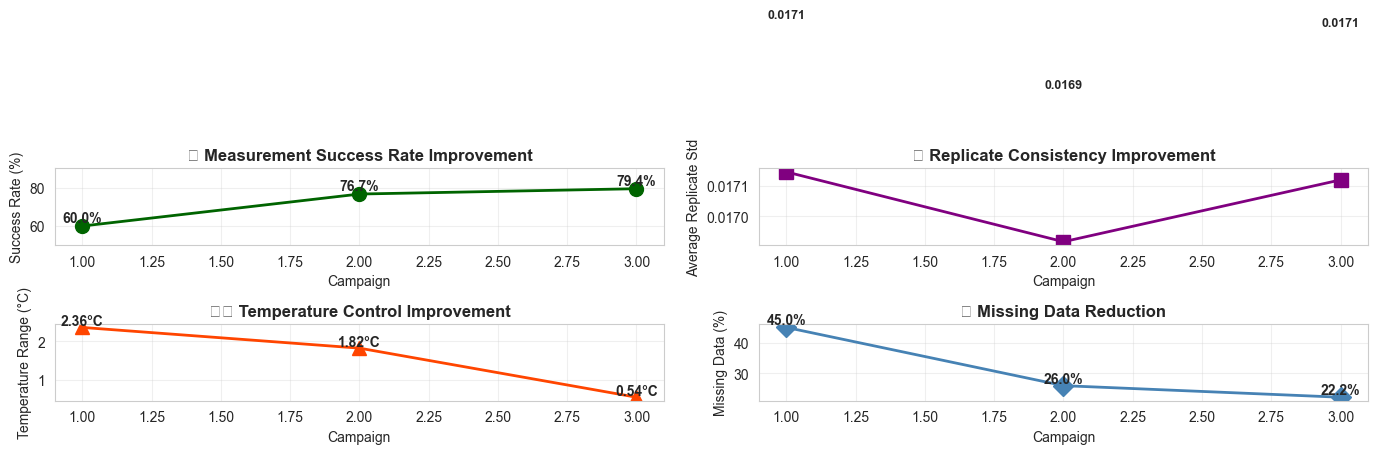


🎯 Key Improvements from Campaign 1 → 3:
  • Success rate: +19.4 percentage points
  • Temperature control: 1.82°C tighter
  • Replicate consistency: 0.2% better

✓ Learning is compounding across campaigns!


In [2]:
# Calculate quality metrics per campaign
quality_evolution = []

for campaign_id, df in campaigns.items():
    metrics = {
        'Campaign': campaign_id,
        'Success_Rate_%': (df['measurement_quality'] == 1).sum() / len(df) * 100,
        'Avg_Replicate_Std': df['replicate_std'].mean(),
        'Temp_Range_C': df['temperature_C'].max() - df['temperature_C'].min(),
        'Missing_Data_%': (df[['overpotential_V', 'tafel_slope_mV_dec']].isnull().sum().sum() / 
                           (len(df) * 2)) * 100,
        'Samples': len(df)
    }
    quality_evolution.append(metrics)

df_quality = pd.DataFrame(quality_evolution)
print("Campaign Quality Evolution:")
print(df_quality.to_string(index=False))

# Visualize improvements
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Success rate improvement
ax1 = axes[0, 0]
ax1.plot(df_quality['Campaign'], df_quality['Success_Rate_%'], 
         marker='o', linewidth=2, markersize=10, color='darkgreen')
for i, row in df_quality.iterrows():
    ax1.text(row['Campaign'], row['Success_Rate_%'] + 2, f"{row['Success_Rate_%']:.1f}%", 
             ha='center', fontweight='bold')
ax1.set_xlabel('Campaign')
ax1.set_ylabel('Success Rate (%)')
ax1.set_title('✅ Measurement Success Rate Improvement', fontsize=12, fontweight='bold')
ax1.set_ylim([50, 90])
ax1.grid(True, alpha=0.3)

# Replicate consistency improvement
ax2 = axes[0, 1]
ax2.plot(df_quality['Campaign'], df_quality['Avg_Replicate_Std'], 
         marker='s', linewidth=2, markersize=10, color='purple')
for i, row in df_quality.iterrows():
    ax2.text(row['Campaign'], row['Avg_Replicate_Std'] + 0.0005, f"{row['Avg_Replicate_Std']:.4f}", 
             ha='center', fontweight='bold', fontsize=9)
ax2.set_xlabel('Campaign')
ax2.set_ylabel('Average Replicate Std')
ax2.set_title('📊 Replicate Consistency Improvement', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Temperature control improvement
ax3 = axes[1, 0]
ax3.plot(df_quality['Campaign'], df_quality['Temp_Range_C'], 
         marker='^', linewidth=2, markersize=10, color='orangered')
for i, row in df_quality.iterrows():
    ax3.text(row['Campaign'], row['Temp_Range_C'] + 0.05, f"{row['Temp_Range_C']:.2f}°C", 
             ha='center', fontweight='bold')
ax3.set_xlabel('Campaign')
ax3.set_ylabel('Temperature Range (°C)')
ax3.set_title('🌡️ Temperature Control Improvement', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Missing data reduction
ax4 = axes[1, 1]
ax4.plot(df_quality['Campaign'], df_quality['Missing_Data_%'], 
         marker='D', linewidth=2, markersize=10, color='steelblue')
for i, row in df_quality.iterrows():
    ax4.text(row['Campaign'], row['Missing_Data_%'] + 1, f"{row['Missing_Data_%']:.1f}%", 
             ha='center', fontweight='bold')
ax4.set_xlabel('Campaign')
ax4.set_ylabel('Missing Data (%)')
ax4.set_title('📉 Missing Data Reduction', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate improvement rates
success_improvement = df_quality.iloc[-1]['Success_Rate_%'] - df_quality.iloc[0]['Success_Rate_%']
temp_improvement = df_quality.iloc[0]['Temp_Range_C'] - df_quality.iloc[-1]['Temp_Range_C']

print(f"\n🎯 Key Improvements from Campaign 1 → 3:")
print(f"  • Success rate: +{success_improvement:.1f} percentage points")
print(f"  • Temperature control: {temp_improvement:.2f}°C tighter")
print(f"  • Replicate consistency: {(1 - df_quality.iloc[-1]['Avg_Replicate_Std']/df_quality.iloc[0]['Avg_Replicate_Std'])*100:.1f}% better")
print(f"\n✓ Learning is compounding across campaigns!")

## 3. Performance Trends: Are We Finding Better Catalysts?

**Key question:** Is catalyst activity improving as we explore composition space?

Catalyst Performance Evolution:
 Campaign  Best_Overpotential_V  Median_Overpotential_V  Best_Tafel_Slope  Median_Tafel_Slope  High_Activity_Count  High_Activity_%
        1                0.1884                 0.25700              30.0                55.9                    8        11.111111
        2                0.1897                 0.26160              30.0                63.8                   24        20.869565
        3                0.1769                 0.25715              30.0                57.6                   26        18.181818


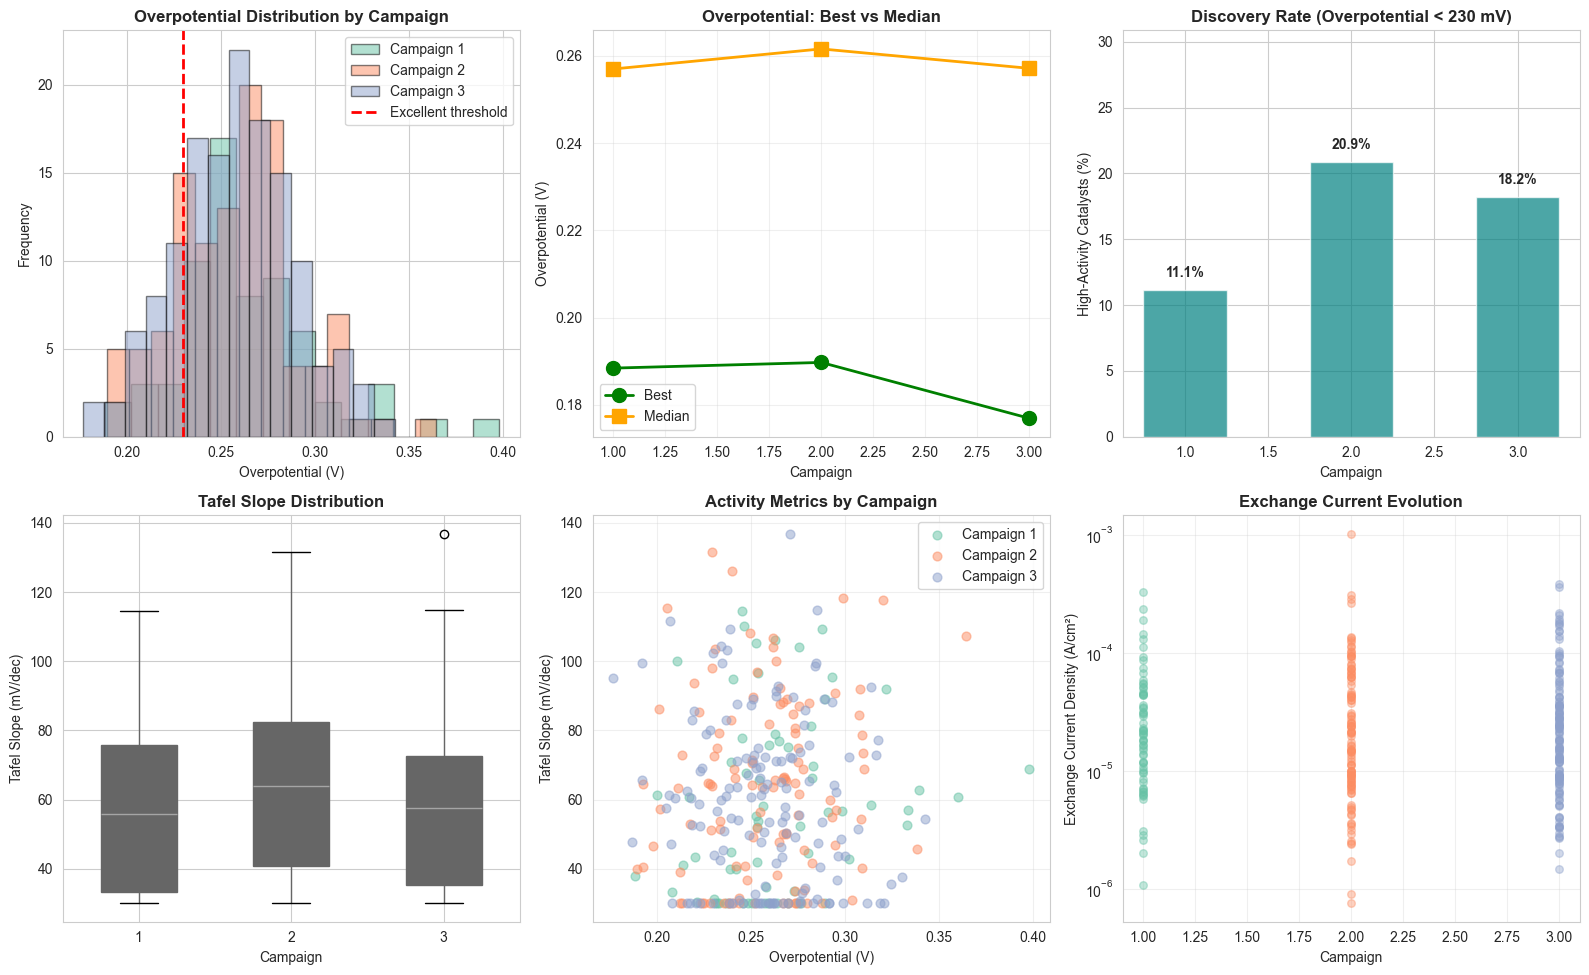


🎯 Performance Insights:
  • Best overpotential improved by 11.5 mV
  • High-activity discovery rate increased 7.1 percentage points
  • Campaign 3 found 26.0 excellent catalysts


In [3]:
# Filter for valid measurements only
df_all_valid = df_all[df_all['measurement_quality'] == 1].copy()

# Calculate performance statistics per campaign
performance_stats = []

for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    
    stats = {
        'Campaign': campaign_id,
        'Best_Overpotential_V': df_camp['overpotential_V'].min(),
        'Median_Overpotential_V': df_camp['overpotential_V'].median(),
        'Best_Tafel_Slope': df_camp['tafel_slope_mV_dec'].min(),
        'Median_Tafel_Slope': df_camp['tafel_slope_mV_dec'].median(),
        'High_Activity_Count': (df_camp['overpotential_V'] < 0.23).sum(),  # < 230 mV is excellent
        'High_Activity_%': (df_camp['overpotential_V'] < 0.23).sum() / len(df_camp) * 100
    }
    performance_stats.append(stats)

df_performance = pd.DataFrame(performance_stats)
print("Catalyst Performance Evolution:")
print(df_performance.to_string(index=False))

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Overpotential distributions by campaign
ax1 = axes[0, 0]
for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    ax1.hist(df_camp['overpotential_V'], bins=15, alpha=0.5, label=f'Campaign {campaign_id}', edgecolor='black')
ax1.axvline(x=0.23, color='red', linestyle='--', label='Excellent threshold', linewidth=2)
ax1.set_xlabel('Overpotential (V)')
ax1.set_ylabel('Frequency')
ax1.set_title('Overpotential Distribution by Campaign', fontweight='bold')
ax1.legend()

# Best overpotential trend
ax2 = axes[0, 1]
ax2.plot(df_performance['Campaign'], df_performance['Best_Overpotential_V'], 
         marker='o', linewidth=2, markersize=10, color='green', label='Best')
ax2.plot(df_performance['Campaign'], df_performance['Median_Overpotential_V'], 
         marker='s', linewidth=2, markersize=10, color='orange', label='Median')
ax2.set_xlabel('Campaign')
ax2.set_ylabel('Overpotential (V)')
ax2.set_title('Overpotential: Best vs Median', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# High-activity catalyst discovery rate
ax3 = axes[0, 2]
ax3.bar(df_performance['Campaign'], df_performance['High_Activity_%'], color='teal', width=0.5, alpha=0.7)
for i, row in df_performance.iterrows():
    ax3.text(row['Campaign'], row['High_Activity_%'] + 1, f"{row['High_Activity_%']:.1f}%", 
             ha='center', fontweight='bold')
ax3.set_xlabel('Campaign')
ax3.set_ylabel('High-Activity Catalysts (%)')
ax3.set_title('Discovery Rate (Overpotential < 230 mV)', fontweight='bold')
ax3.set_ylim([0, max(df_performance['High_Activity_%']) + 10])

# Tafel slope distributions
ax4 = axes[1, 0]
campaign_colors = ['skyblue', 'lightcoral', 'lightgreen']
df_all_valid.boxplot(column='tafel_slope_mV_dec', by='campaign', ax=ax4, 
                      patch_artist=True, widths=0.5)
ax4.set_xlabel('Campaign')
ax4.set_ylabel('Tafel Slope (mV/dec)')
ax4.set_title('Tafel Slope Distribution', fontweight='bold')
plt.suptitle('')

# Scatter: Overpotential vs Tafel slope (colored by campaign)
ax5 = axes[1, 1]
for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    ax5.scatter(df_camp['overpotential_V'], df_camp['tafel_slope_mV_dec'], 
                alpha=0.5, s=40, label=f'Campaign {campaign_id}')
ax5.set_xlabel('Overpotential (V)')
ax5.set_ylabel('Tafel Slope (mV/dec)')
ax5.set_title('Activity Metrics by Campaign', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Exchange current density trend
ax6 = axes[1, 2]
for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    ax6.scatter([campaign_id] * len(df_camp), df_camp['exchange_current_A_cm2'], 
                alpha=0.4, s=30)
ax6.set_xlabel('Campaign')
ax6.set_ylabel('Exchange Current Density (A/cm²)')
ax6.set_title('Exchange Current Evolution', fontweight='bold')
ax6.set_yscale('log')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
best_improvement = df_performance.iloc[0]['Best_Overpotential_V'] - df_performance.iloc[-1]['Best_Overpotential_V']
discovery_improvement = df_performance.iloc[-1]['High_Activity_%'] - df_performance.iloc[0]['High_Activity_%']

print(f"\n🎯 Performance Insights:")
print(f"  • Best overpotential improved by {best_improvement*1000:.1f} mV")
print(f"  • High-activity discovery rate increased {discovery_improvement:.1f} percentage points")
print(f"  • Campaign 3 found {df_performance.iloc[-1]['High_Activity_Count']} excellent catalysts")

## 4. Compositional Trends: Learning What Works

**Key question:** Which compositional features consistently predict high activity? Is our understanding stabilizing?

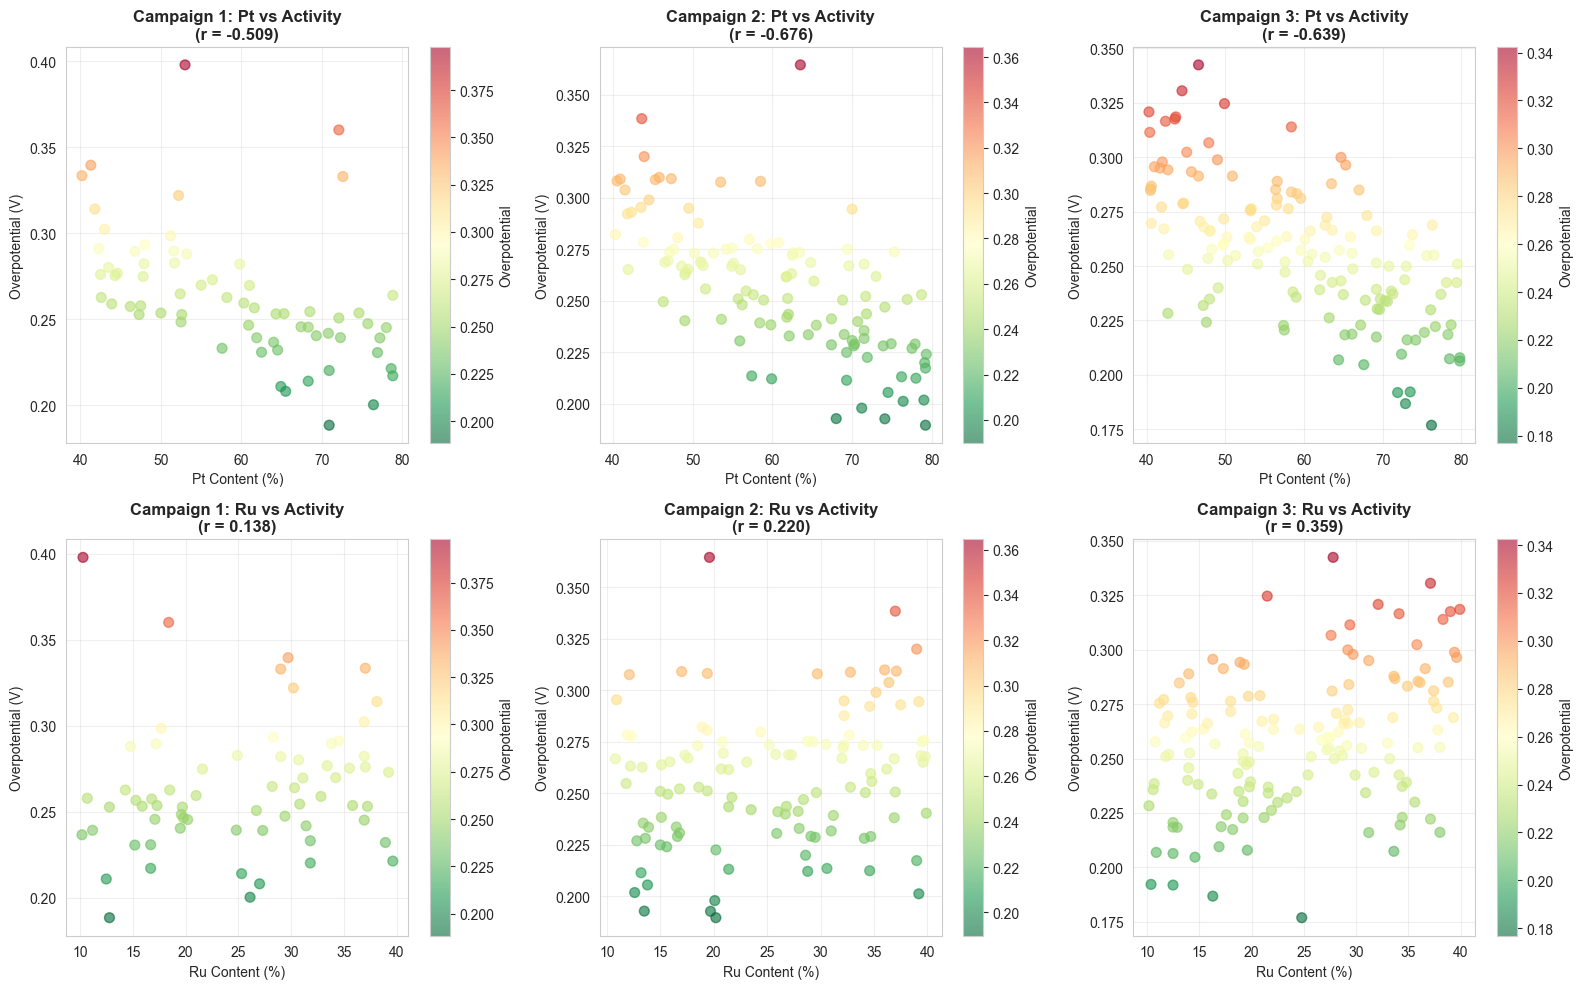

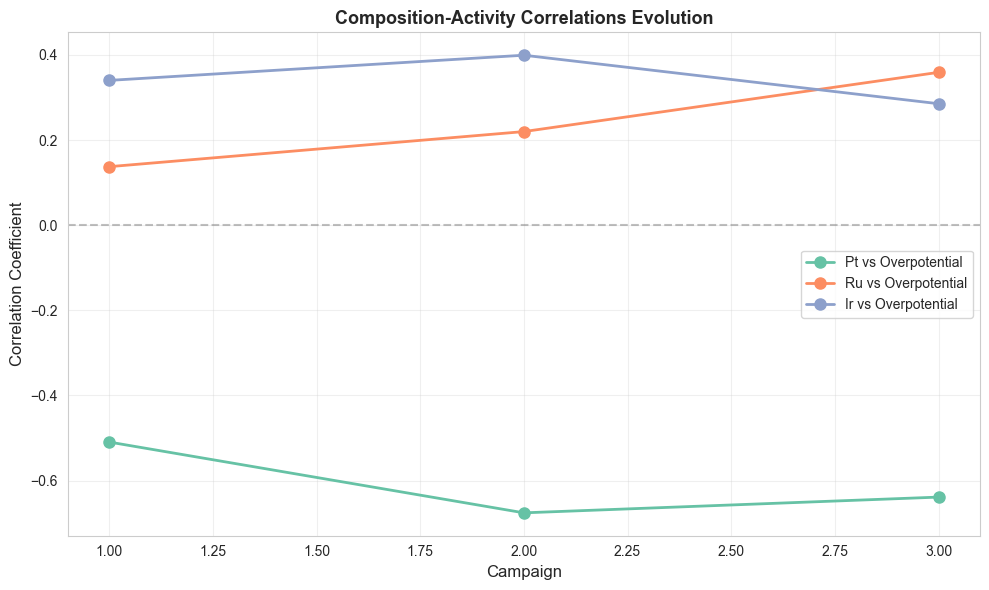

Composition-Activity Correlations by Campaign:
 Campaign  Pt_vs_Overpotential  Ru_vs_Overpotential  Ir_vs_Overpotential  Pt_vs_Tafel
        1            -0.509416             0.137595             0.340286    -0.062751
        2            -0.675726             0.220026             0.399448    -0.000733
        3            -0.638731             0.359197             0.285510     0.095559

📊 Correlation Stability:
  • Pt correlation std dev: 0.087
  • Status: ✓ Stable understanding (low variability)


In [4]:
# Analyze composition-activity relationships per campaign
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

for idx, campaign_id in enumerate([1, 2, 3]):
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    
    # Pt content vs overpotential
    ax1 = axes[0, idx]
    scatter = ax1.scatter(df_camp['Pt_percent'], df_camp['overpotential_V'], 
                         c=df_camp['overpotential_V'], cmap='RdYlGn_r', alpha=0.6, s=50)
    correlation = df_camp[['Pt_percent', 'overpotential_V']].corr().iloc[0, 1]
    ax1.set_xlabel('Pt Content (%)')
    ax1.set_ylabel('Overpotential (V)')
    ax1.set_title(f'Campaign {campaign_id}: Pt vs Activity\n(r = {correlation:.3f})', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Overpotential')
    
    # Ru content vs overpotential
    ax2 = axes[1, idx]
    scatter = ax2.scatter(df_camp['Ru_percent'], df_camp['overpotential_V'], 
                         c=df_camp['overpotential_V'], cmap='RdYlGn_r', alpha=0.6, s=50)
    correlation = df_camp[['Ru_percent', 'overpotential_V']].corr().iloc[0, 1]
    ax2.set_xlabel('Ru Content (%)')
    ax2.set_ylabel('Overpotential (V)')
    ax2.set_title(f'Campaign {campaign_id}: Ru vs Activity\n(r = {correlation:.3f})', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax2, label='Overpotential')

plt.tight_layout()
plt.show()

# Calculate correlation stability across campaigns
correlations_evolution = []

for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id]
    corr = {
        'Campaign': campaign_id,
        'Pt_vs_Overpotential': df_camp[['Pt_percent', 'overpotential_V']].corr().iloc[0, 1],
        'Ru_vs_Overpotential': df_camp[['Ru_percent', 'overpotential_V']].corr().iloc[0, 1],
        'Ir_vs_Overpotential': df_camp[['Ir_percent', 'overpotential_V']].corr().iloc[0, 1],
        'Pt_vs_Tafel': df_camp[['Pt_percent', 'tafel_slope_mV_dec']].corr().iloc[0, 1]
    }
    correlations_evolution.append(corr)

df_corr = pd.DataFrame(correlations_evolution)

# Plot correlation evolution
fig, ax = plt.subplots(figsize=(10, 6))
for col in ['Pt_vs_Overpotential', 'Ru_vs_Overpotential', 'Ir_vs_Overpotential']:
    ax.plot(df_corr['Campaign'], df_corr[col], marker='o', linewidth=2, 
            markersize=8, label=col.replace('_vs_', ' vs '))

ax.set_xlabel('Campaign', fontsize=12)
ax.set_ylabel('Correlation Coefficient', fontsize=12)
ax.set_title('Composition-Activity Correlations Evolution', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Composition-Activity Correlations by Campaign:")
print(df_corr.to_string(index=False))

# Stability analysis
pt_corr_std = df_corr['Pt_vs_Overpotential'].std()
print(f"\n📊 Correlation Stability:")
print(f"  • Pt correlation std dev: {pt_corr_std:.3f}")
if pt_corr_std < 0.1:
    print(f"  • Status: ✓ Stable understanding (low variability)")
else:
    print(f"  • Status: ⚠️ Understanding still evolving")

## 5. Feature Importance Evolution: What Predicts Activity?

Use Random Forest to identify which features best predict overpotential, and track if feature importance stabilizes across campaigns.

Feature Importance Evolution:
 Campaign     R2_CV  Pt_percent  Ru_percent  Ir_percent  surface_area_m2_g  temperature_C       pH
        1 -0.019262    0.421221    0.145560    0.063784           0.080518       0.195327 0.093589
        2  0.282813    0.662791    0.107262    0.070017           0.059361       0.040513 0.060056
        3  0.287071    0.552696    0.216827    0.045279           0.061660       0.062833 0.060704


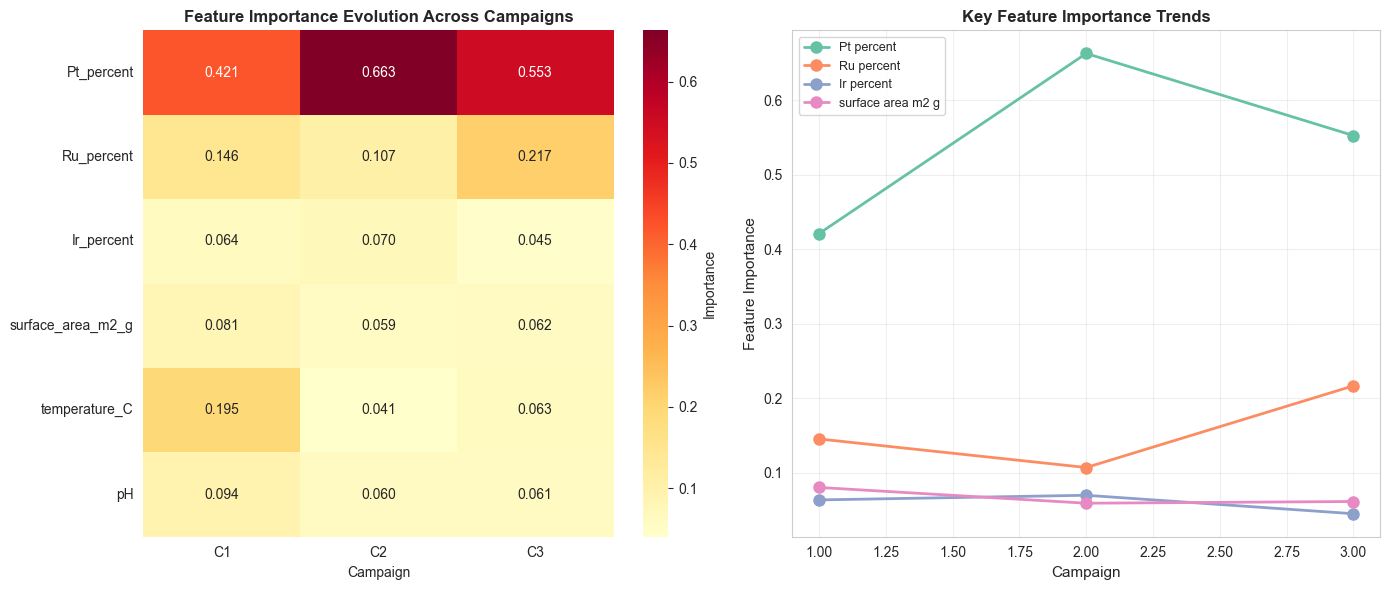


🤖 Predictive Model Performance:
  Campaign 1: R² = -0.019
  Campaign 2: R² = 0.283
  Campaign 3: R² = 0.287

📊 Feature Importance Stability (lower std = more stable):
  • surface_area_m2_g: 0.0116
  • Ir_percent: 0.0129
  • pH: 0.0192
  • Ru_percent: 0.0556
  • temperature_C: 0.0837
  • Pt_percent: 0.1209


In [6]:
# Define features for modeling
feature_cols = ['Pt_percent', 'Ru_percent', 'Ir_percent', 'surface_area_m2_g', 
                'temperature_C', 'pH']
target = 'overpotential_V'

# Train models per campaign and extract feature importances
importance_evolution = []

for campaign_id in [1, 2, 3]:
    df_camp = df_all_valid[df_all_valid['campaign'] == campaign_id].copy()
    
    # Prepare data - drop rows with NaN in target or features
    df_model = df_camp[feature_cols + [target]].dropna()
    X = df_model[feature_cols]
    y = df_model[target]
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X, y)
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X, y, cv=3, scoring='r2')
    
    # Store importances
    importance_dict = {'Campaign': campaign_id, 'R2_CV': cv_scores.mean()}
    for feat, imp in zip(feature_cols, rf.feature_importances_):
        importance_dict[feat] = imp
    
    importance_evolution.append(importance_dict)

df_importance = pd.DataFrame(importance_evolution)

print("Feature Importance Evolution:")
print(df_importance.to_string(index=False))

# Visualize feature importance evolution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Feature importance heatmap
ax1 = axes[0]
importance_matrix = df_importance[feature_cols].T
sns.heatmap(importance_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
            xticklabels=[f'C{i}' for i in [1, 2, 3]], 
            yticklabels=feature_cols, ax=ax1, cbar_kws={'label': 'Importance'})
ax1.set_title('Feature Importance Evolution Across Campaigns', fontweight='bold', fontsize=12)
ax1.set_xlabel('Campaign')

# Feature importance trends
ax2 = axes[1]
for feat in ['Pt_percent', 'Ru_percent', 'Ir_percent', 'surface_area_m2_g']:
    ax2.plot(df_importance['Campaign'], df_importance[feat], 
             marker='o', linewidth=2, markersize=8, label=feat.replace('_', ' '))
ax2.set_xlabel('Campaign', fontsize=11)
ax2.set_ylabel('Feature Importance', fontsize=11)
ax2.set_title('Key Feature Importance Trends', fontweight='bold', fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model performance evolution
print(f"\n🤖 Predictive Model Performance:")
for idx, row in df_importance.iterrows():
    print(f"  Campaign {int(row['Campaign'])}: R² = {row['R2_CV']:.3f}")

# Identify stable features (low variance in importance)
feature_stability = {}
for feat in feature_cols:
    feature_stability[feat] = df_importance[feat].std()

print(f"\n📊 Feature Importance Stability (lower std = more stable):")
for feat, std in sorted(feature_stability.items(), key=lambda x: x[1]):
    print(f"  • {feat}: {std:.4f}")

## 6. Recommendations for Campaign 4

Based on what we've learned across campaigns 1-3, what should the next campaign prioritize?

In [7]:
# Identify best-performing composition ranges
df_top_performers = df_all_valid.nsmallest(20, 'overpotential_V')

print("="*70)
print("CAMPAIGN 4 RECOMMENDATIONS")
print("="*70)

print(f"\n1. COMPOSITION OPTIMIZATION")
print(f"   Top 20 catalysts analysis:")
print(f"   • Pt range: {df_top_performers['Pt_percent'].min():.1f}-{df_top_performers['Pt_percent'].max():.1f}%")
print(f"     Median: {df_top_performers['Pt_percent'].median():.1f}%")
print(f"   • Ru range: {df_top_performers['Ru_percent'].min():.1f}-{df_top_performers['Ru_percent'].max():.1f}%")
print(f"     Median: {df_top_performers['Ru_percent'].median():.1f}%")
print(f"   • Ir range: {df_top_performers['Ir_percent'].min():.1f}-{df_top_performers['Ir_percent'].max():.1f}%")
print(f"     Median: {df_top_performers['Ir_percent'].median():.1f}%")

# Identify most important features
most_important = df_importance.iloc[-1][feature_cols].idxmax()
importance_value = df_importance.iloc[-1][most_important]
print(f"\n2. FEATURE PRIORITIZATION")
print(f"   • Most predictive feature: {most_important} (importance: {importance_value:.3f})")
print(f"   • Recommendation: Design experiments that vary {most_important} systematically")

# Data quality continuation
print(f"\n3. MAINTAIN DATA QUALITY IMPROVEMENTS")
print(f"   • Target success rate: >85% (Campaign 3 achieved {df_quality.iloc[-1]['Success_Rate_%']:.1f}%)")
print(f"   • Temperature control: Maintain ±0.5°C")
print(f"   • Continue operator training program")

# Exploration vs exploitation strategy
high_activity_rate_c3 = df_performance.iloc[-1]['High_Activity_%']
print(f"\n4. EXPLORATION STRATEGY")
print(f"   • Campaign 3 high-activity rate: {high_activity_rate_c3:.1f}%")
if high_activity_rate_c3 > 15:
    print(f"   • Recommendation: 70% exploitation (refine winners), 30% exploration")
else:
    print(f"   • Recommendation: 50% exploitation, 50% exploration (keep searching)")

# Specific compositions to test
print(f"\n5. PRIORITY COMPOSITIONS TO TEST")
print(f"   Based on top performers, suggest:")

optimal_pt = df_top_performers['Pt_percent'].median()
optimal_ru = df_top_performers['Ru_percent'].median()
optimal_ir = 100 - optimal_pt - optimal_ru

print(f"   • Composition 1: Pt {optimal_pt:.0f}%, Ru {optimal_ru:.0f}%, Ir {optimal_ir:.0f}%")
print(f"   • Composition 2: Pt {optimal_pt+5:.0f}%, Ru {optimal_ru-3:.0f}%, Ir {optimal_ir-2:.0f}%")
print(f"   • Composition 3: Pt {optimal_pt-5:.0f}%, Ru {optimal_ru+3:.0f}%, Ir {optimal_ir+2:.0f}%")

# Experimental validation priorities
print(f"\n6. VALIDATION & FOLLOW-UP")
outliers_to_validate = df_all_valid[
    (df_all_valid['campaign'] == 3) & 
    (df_all_valid['overpotential_V'] < 0.21)
]
print(f"   • Re-test {len(outliers_to_validate)} exceptional performers from Campaign 3")
print(f"   • Perform long-term stability tests on best 5 catalysts")
print(f"   • Consider DFT calculations for top 3 performers")

print(f"\n{'='*70}")
print(f"✓ Campaign 4 strategy complete - ready to implement!")
print(f"{'='*70}")

CAMPAIGN 4 RECOMMENDATIONS

1. COMPOSITION OPTIMIZATION
   Top 20 catalysts analysis:
   • Pt range: 64.4-79.8%
     Median: 73.8%
   • Ru range: 10.4-39.2%
     Median: 16.6%
   • Ir range: -15.6-24.7%
     Median: 8.6%

2. FEATURE PRIORITIZATION
   • Most predictive feature: Pt_percent (importance: 0.553)
   • Recommendation: Design experiments that vary Pt_percent systematically

3. MAINTAIN DATA QUALITY IMPROVEMENTS
   • Target success rate: >85% (Campaign 3 achieved 79.4%)
   • Temperature control: Maintain ±0.5°C
   • Continue operator training program

4. EXPLORATION STRATEGY
   • Campaign 3 high-activity rate: 18.2%
   • Recommendation: 70% exploitation (refine winners), 30% exploration

5. PRIORITY COMPOSITIONS TO TEST
   Based on top performers, suggest:
   • Composition 1: Pt 74%, Ru 17%, Ir 10%
   • Composition 2: Pt 79%, Ru 14%, Ir 8%
   • Composition 3: Pt 69%, Ru 20%, Ir 12%

6. VALIDATION & FOLLOW-UP
   • Re-test 10 exceptional performers from Campaign 3
   • Perform lo